In [1]:
# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
# from pyearth import Earth

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

# home brew utitilties
import resources.utility_functions as ut

# import resources.abundance_classes as ac
import resources.chart_kwargs as ck
import resources.sr_ut as sut

# images and display
import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md

# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2020-03-01'
end_date ='2021-05-31'
a_fail_rate = .5

# name of the output folder:
name_of_project = 'land_use_correlation_method'

# add the folder to the directory tree:
project_directory = ut.make_project_folder('output', name_of_project)

# get your data:
survey_data = pd.read_csv('resources/results_with_land_use_2015.csv')
river_bassins = ut.json_file_get("resources/river_basins.json")
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
dfDims = pd.read_csv("resources/dims_data.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# set the code index and edit descriptions for display:
dfCodes.set_index('code', inplace=True)

# make a map to the code descriptions
code_description_map = dfCodes.description

# these descriptions need to be shortened for display
dfCodes = sut.shorten_the_value(["G74", "description", "Insulation: includes spray foams"], dfCodes)
dfCodes = sut.shorten_the_value(["G940", "description", "Foamed EVA for crafts and sports"], dfCodes)
dfCodes = sut.shorten_the_value(["G96", "description", "Sanitary-pads/panty liners/tampons"], dfCodes)
dfCodes = sut.shorten_the_value(["G178", "description", "Metal bottle caps and lids"], dfCodes)

## Survey results and local land use features

#### Land use is a method to differentiate survey sites in other ways besides location or population. The land use mix is a unique representation of the type and amplititude of econmic activity around the survey location.

Trash is a collection of objects whose abundance in the natural environment are a reflection of their utility and use. The object type and the context in which it is found gives plenty of indicators as to its origin geographically and economically. How the land is used in proximity to the survey location is an important context to consider when evaluating survey results.<sup>4,5,6</sup>

In September 2020 the European Union issued beach-litter baselines and target values<sup>7</sup>. After considering the many factors, including the transparency of the calculation method the EU decided that the median value of survey results would be used to compare surveys<sup>8</sup>. **This has incited interest in communities to better indentify and quantify point sources of trash as they attempt to find the most efficient way to meet target values**.<sup>12</sup> Identifying relevant land use patterns and features is an essential element in the process.

### Defining the land use categories

The land use rates were compared to the beach litter survey results for each survey location and tested for the following conditions:

* Under what land use rates (if any) can we expect to find more or less trash?
* What specific objects are most likely to be effected by land use rates?

For this example land use is grouped into three sections:

1. Consumption, interaction
   * areas for buildings
   * areas for recreation
2. Agriculture, forests
   * areas for aggriculture and pasture
   * areas for woodlands and meadows
3. Transport
   * length of roads
   * number of intersecting rivers and canals
   
### Calculating land use

The Office fédéral de la statistique provides the 'Statistique de superficie'², a grid of points 100m x 100m that covers Switzerland. Each point is assigned one of 72 different land use categories. This grid, as well as the relevant map layers from swissTLMRegio³ are the basis of determining these values. River discharge points and the length of streets is extracted from the relevant map layer using QGIS.

The land use mix within 1500 meters around each survey location was evaluated for the following criteria:

1. % of surface area attributed to buildings
2. % of surface area left to woods
3. % of surface area attributed to outdoor activities
4. % of surface area attributed to aggriculture
5. length in meters of all roadways 
6. number of river discharge intersections

The data for the first four attributes was taken from the Statistique suisse de superficie using the data for the survey 2013/18 (AS1827). The points representing the different land use attributes were added together and divided by the total number of points within the 1500m buffer **not attributed to a water feature**. The street length was calculated using the streets layer from swissTLMRegio². Once the length in each buffer was calculated the lengths were ranked in ascending order.

The number of river discharge intersections is the number of streams/rivers/canals that empty into the lake of interest within 1500m of the survey location. This information is obtained by intersecting the streams layer with the lakes layer from swissTLMRegio². The following figures demonstrate the maps and how the different attributes are calculated.


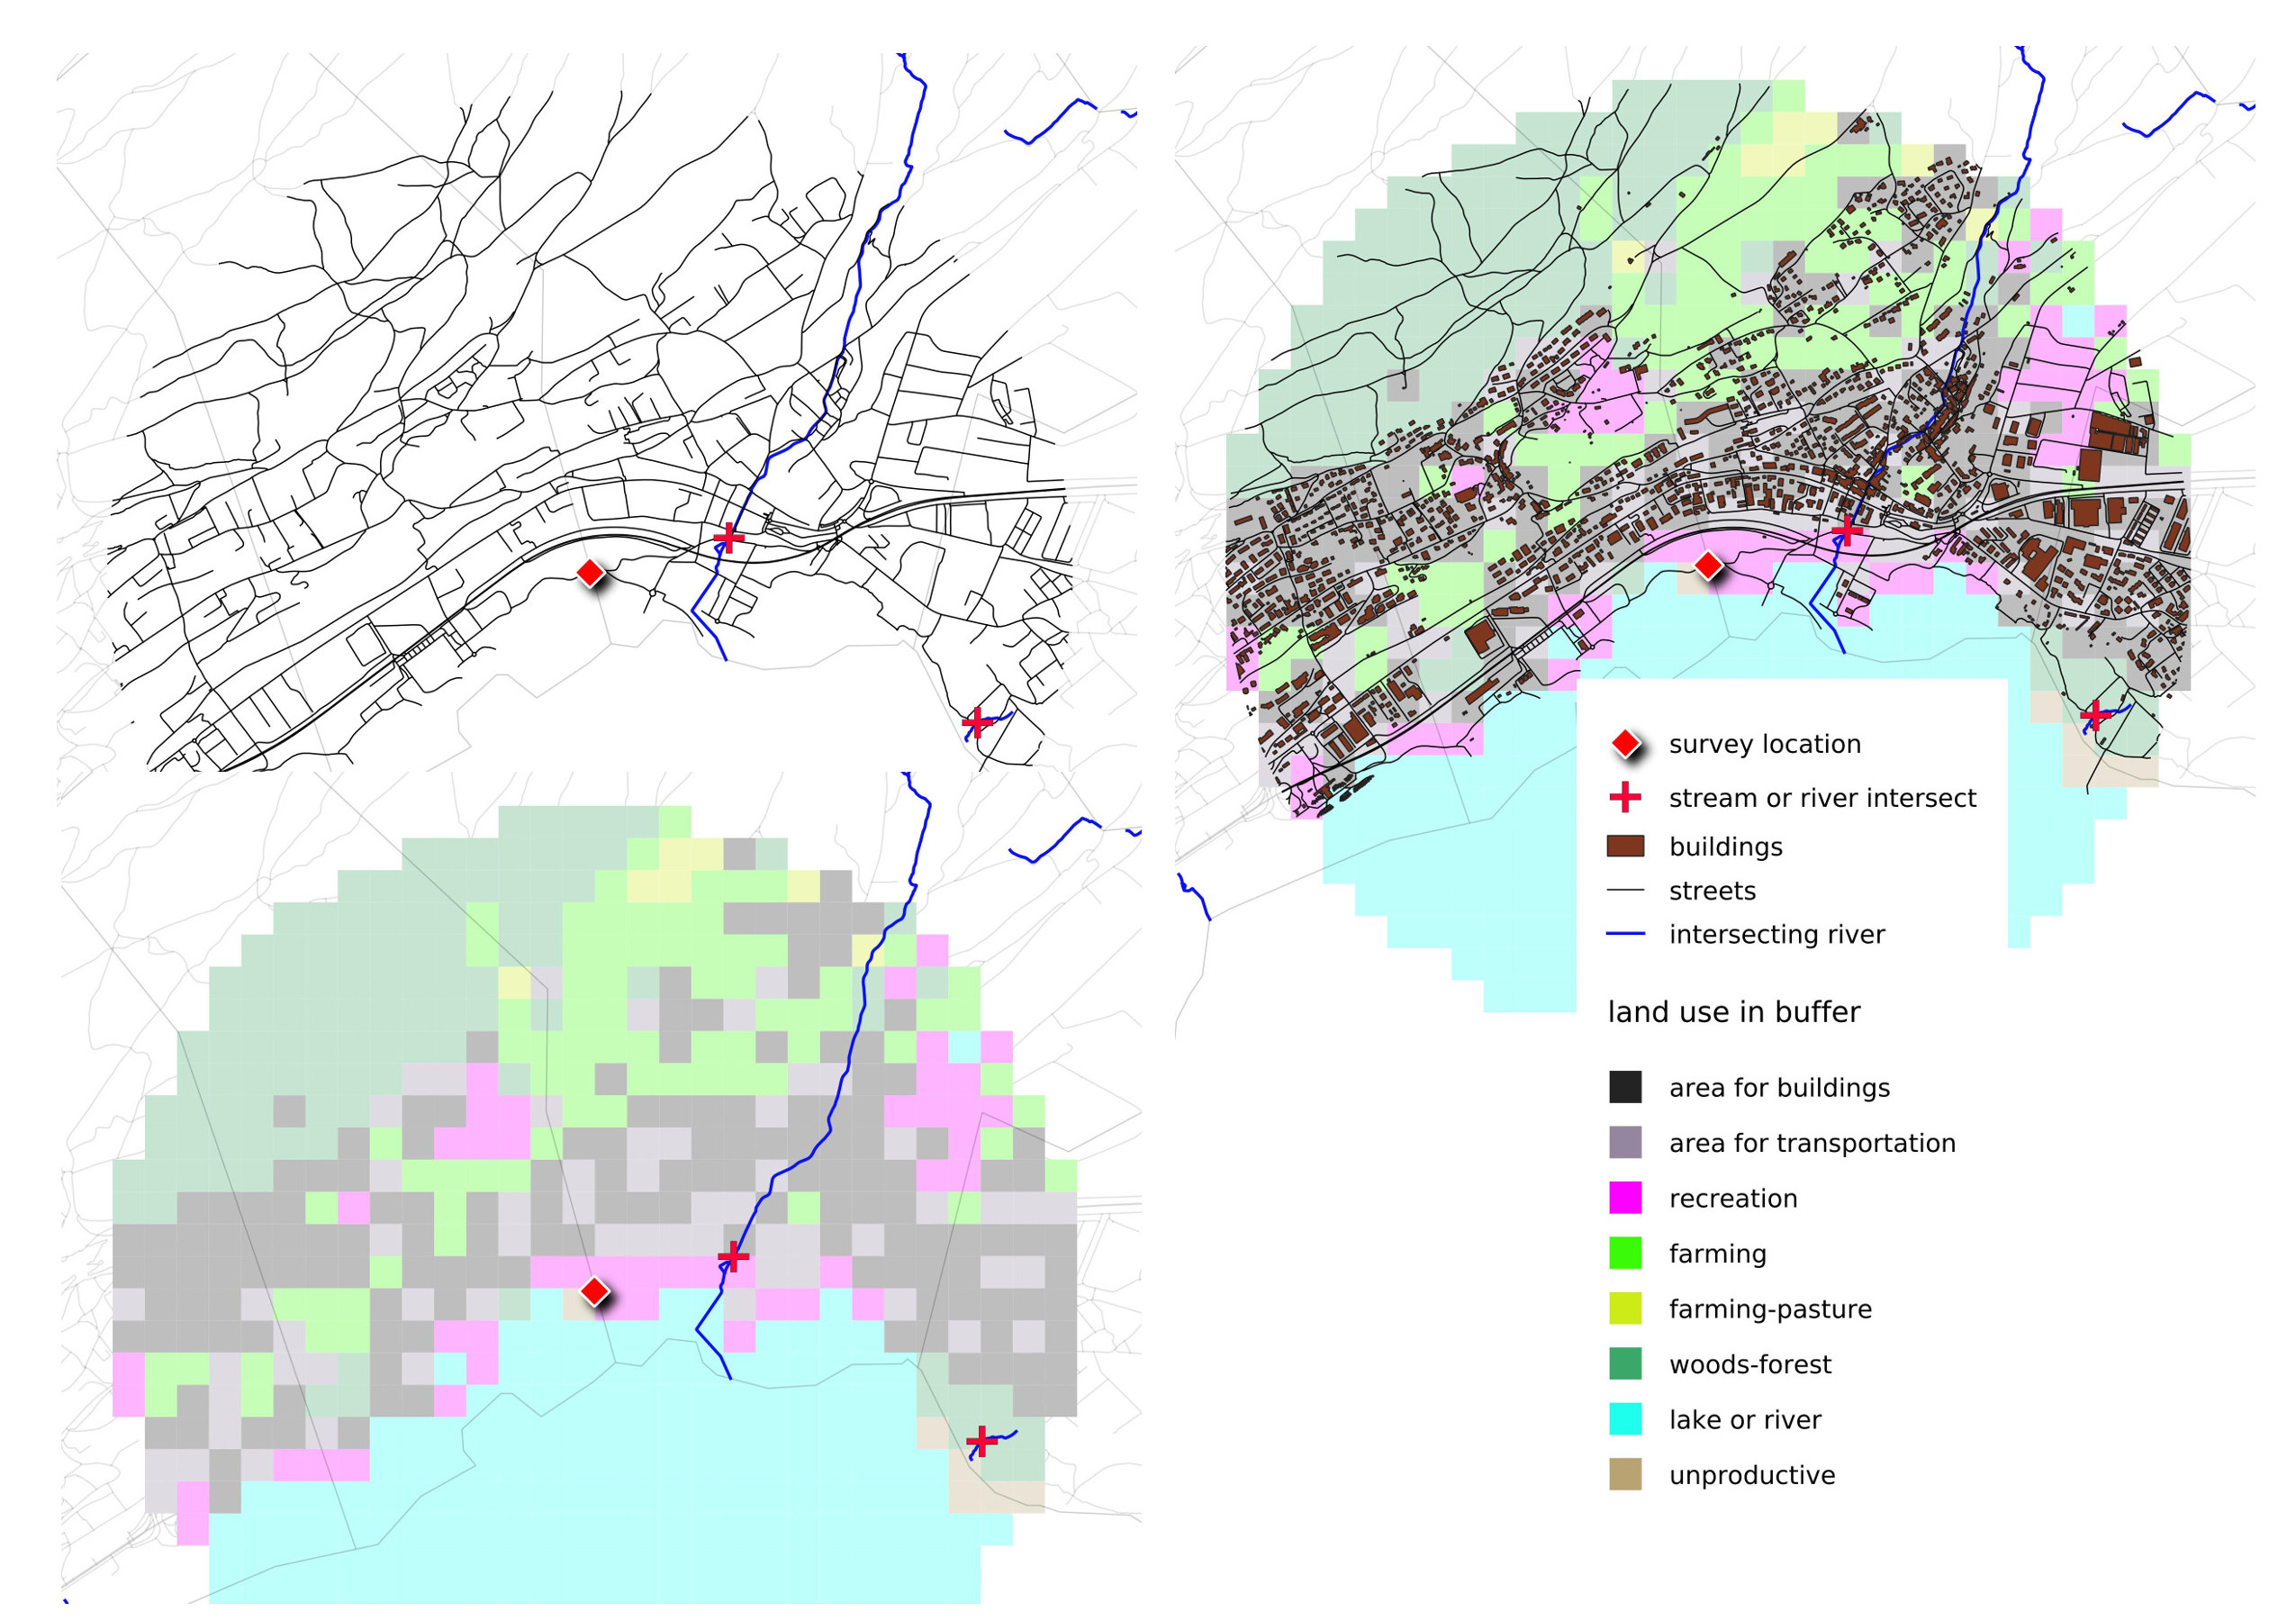

In [2]:
output = io.BytesIO()
a_map=PILImage.open("resources/maps/landuse_all_disp.jpeg")
a_map.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
IPython.display.HTML(html)

In [3]:
# explanatory variables:
luse_exp = ['% to buildings', '% to recreation', '% to agg', '% to woods', 'streets km', 'intersects']



# columns needed
use_these_cols = ['loc_date' ,'% to buildings', '% to trans', '% to recreation', '% to agg',
                  '% to woods','population','water_name_slug', 'streets km', 'intersects', 'groupname','code']
survey_data = survey_data[(survey_data.water_name_slug != 'walensee')&(survey_data.date >= start_date)&(survey_data.date <= end_date)].copy()
survey_data.rename(columns={'str_rank':'street rank'}, inplace=True)
survey_data['streets km'] = survey_data.streets/1000

a_data = survey_data.copy()

# Combine the different sizes of fragmented plastics and styrofoam
# the codes for the foams
some_foams = ['G81', 'G82', 'G83']

# # the codes for the fragmented plastics
some_frag_plas = list(a_data[a_data.groupname == 'plastic pieces'].code.unique())

the_plast_rows = sut.create_aggregate_groups(a_data, codes_to_agg=some_frag_plas,a_model_code="G79", a_new_code="Gfrags")
the_foam_rows = sut.create_aggregate_groups(a_data, codes_to_agg=some_foams, a_model_code="G82", a_new_code="Gfoam")

# the foam codes and fragmented plastic codes have been aggregated in to Gfrags and Gfoam
new_som_data = sut.replace_a_group_of_codes_with_one(a_data, new_code_values=[the_plast_rows, the_foam_rows], codes_to_replace=[*some_frag_plas, *some_foams])

# keep the orginal data to test on

# survey totals
dfdt = new_som_data.groupby(use_these_cols[:-2], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})

# method to get the ranked correlation of pcs_m to each explanatory variable
def make_plot_with_spearmans(data, ax, n):
    sns.scatterplot(data=data, x=n, y='pcs_m', ax=ax, color='black', s=30, edgecolor='white', alpha=0.6)
    corr = stats.spearmanr(data[n], data['pcs_m']).correlation
    a_p = stats.spearmanr(data[n], data['pcs_m']).pvalue
    return ax, corr, a_p

### Land use profile of the survey locations

The distribution of the number of surveys completed at the different land use rates. The land use is reported as the percent of total area attributed to each land use category within a 1500m  radius of the survey location. Street rank is the ordinal ranking of the length of all streets/pathways within the 1500m buffer.  Intersects is also an ordinal ranking of the number of rivers/canals that intersect a lake within 1500m of the survey location.

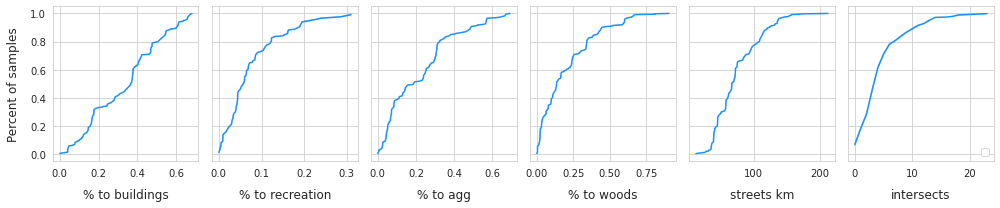

In [4]:
# group the explanatory variables and count the number of surveys for the different landuse values
sns.set_style("whitegrid")
fig, axs = plt.subplots(1,len(luse_exp), figsize=(14,3), sharey=True)

data = dfdt.copy()

for i, n in enumerate(luse_exp):
    ax=axs[i]
    the_data = ECDF(data[n].values)
    x, y = the_data.x, the_data.y   
    
    sns.lineplot(x=x, y=y, ax=ax, color='dodgerblue')
    
    if i == 0:
        ax.set_ylabel("Percent of samples", **ck.xlab_k)
    else:
        pass
    ax.set_xlabel(n, **ck.xlab_k)
    
handles, labels=ax.get_legend_handles_labels() 
ax.legend(handles, labels, loc='lower right')

plt.tight_layout()
plt.show()


In [5]:
# nsamps = len(dfdt)
# a_summ_lu = {x:new_som_data[new_som_data[x] <= .2].loc_date.nunique()/nsamps for x in luse_exp[:-2]}
# print(a_summ_lu)

# a_mean_lu =  {x:new_som_data[x].mean() for x in luse_exp[:-2]}
# print("the mean")
# print(a_mean_lu)
# print("the median")
# a_median_lu =  {x:new_som_data[x].median() for x in luse_exp[:-2]}
# print(a_median_lu)

# a_90_lu =  {x:new_som_data[x].quantile(.9) for x in luse_exp[:-2]}
# print(a_90_lu)

# ints_streets = {x:new_som_data.groupby(x).loc_date.nunique()/nsamps for x in luse_exp[-2:]}
# ints_s_med = {x:new_som_data[x].median() for x in luse_exp[-2:]}
# int_s_mean = {x:new_som_data[x].mean() for x in luse_exp[-2:]}
# print(len(new_som_data[new_som_data['streets km'] <= ints_s_med['streets km']].loc_date.unique()))

# print(ints_s_med)
# print(sorted(new_som_data.streets.unique()))
# print(new_som_data.groupby('loc_date').streets.max().median())
# print(new_som_data["% to buildings"].quantile(a_summ_lu["% to agg"]))

# print(new_som_data.streets.median())

# print(new_som_data.intersects.unique())

# print(new_som_data.population.median())

# new_som_data.population.max()

# dfBeaches[dfBeaches.population == 442]


**The land use** around the survey locations had a higher attribution to buildings as opposed to agriculture and woods. For example, half of all the surveys had at least  34% of land use devoted to buildings as opposed to 12% for agriculture or woods. Land use devoted to recreation was at least 5% for half of all samples. 

**The length of the road network** within the buffer zone differentiates between locations that have other wise similar land use characteristics. The length of road per buffer ranges from 13km to 212km, 50% of the surveys had less than 67km of road network.

**The number of intersections** ranges from zero to 23, 50% of the surveys had 3 or fewer intersections within 1500m of the survey location. The size of the intersecting river or canal was not taken into consideration. Survey locations on rivers have zero intersections.

**The population** (not shown) is taken from statpop 2018 and represents the population of the municipality surounding the survey location. The smallest population was 442 and the maximum was 415,367, 50% of the surveys come from municipalities with a population of at least 12,812.

### Choosing survey sites

The survey locations were chosen based on the following criteria:

1. Data from previous surveys (SLR, MCBP)
2. Year round safe access
3. Within 30 minutes walking distance from nearest public transport

**The survey locations represent the land use conditions accesible to $\approx$ 1.7 million people** and add to the results from previous projects that used a similar protocol. For more information see the document *Survey site selection and criteria*.

### Survey total and land use characteristics

The survey total is reported as pieces of trash per meter¹. The method used is the Spearman's rho or *Spearmans ranked correlation coefficient*³. The test results are evaluated at p<0.05 and 386 samples. The results from all 386 surveys follows. Red/rose is a postitive correlation, yellow is negative and white means that p>0.05, there is no statisitical basis to assume a correlation⁴.

Any correlation at this level relates the certainty that surveys results will be higher or lower as the amount of the attribute increases. The magnitude of the relationship is not defined and it is not linear. 


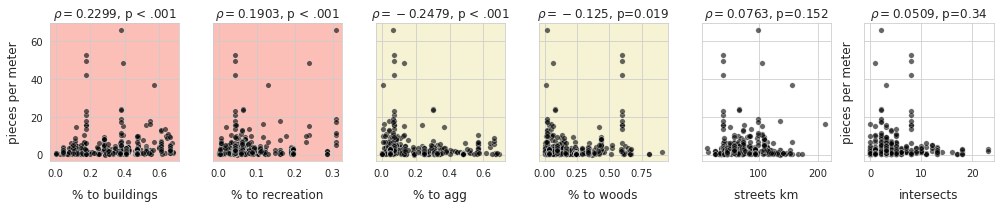

In [6]:
# correlation  of survey total to land use attributes:

fig, axs = plt.subplots(1,len(luse_exp), figsize=(14,3), sharey=True)

for i, n in enumerate(luse_exp):
    ax=axs[i]
    ax, corr, a_p = make_plot_with_spearmans(dfdt, ax, n)
    if i == 0:
        ax.set_ylabel('pieces per meter', **ck.xlab_k)
    ax.set_xlabel(n, **ck.xlab_k)
    if a_p <= .001:
        title_str = "p < .001"
    else:
        title_str = F"p={round(a_p, 3)}"
    
    ax.set_title(rF"$\rho={round(corr,4)}$, {title_str}")
    
    if a_p < 0.05:
        if corr > 0:
            ax.patch.set_facecolor('salmon')
            ax.patch.set_alpha(0.5)
        else:
            ax.patch.set_facecolor('palegoldenrod')
            ax.patch.set_alpha(0.5)

            plt.ylabel('pieces per meter', **ck.xlab_k)
plt.tight_layout()
plt.show()

A correlation is a statistically sound assumption in four out of the six measured attributes, the scatter plots suggest that the upper limit is not defined for any land use category. By subjecting the most common objects found to the same test, the reasons for the observed correlations can be partially explained.

### Most common objects and land use characteristics

**The most common objects are** all objects that were either the ten most abundant by quantity or any object that was indentified in at least 50% of all the surveys. In this way we are accounting for $\approx 68$% of all objects found and counted. These lists are not the same, not all objects that were found 50% of the time are found in large enough quantities to make the "top ten list".

In [7]:
# the number of times an object was found at least once
code_fails = new_som_data.groupby('code').fail.sum()

# the ratio of found/not found
code_fail_rate = code_fails/new_som_data.loc_date.nunique()

# all codes with a fail rate > fail rate
better_than_50 = code_fail_rate[code_fail_rate > a_fail_rate]

some_keys = {
    '% to buildings':'lu_build',
    '% to agg':'lu_agg',
    '% to woods':'lu_woods',
    '% to recreation':'lu_rec',
    '% to trans':'lu_trans',
    '% to meadow':'lu_m',
    'str_rank':'lu_trans',}

code_totals = new_som_data.groupby('code').quantity.sum()

t_ten = code_totals.sort_values(ascending=False)[:10]
tlist = list(t_ten.index)

for code in better_than_50.index:
    if code in t_ten.index:
        pass
    else:
        tlist.append(code)
        

abundant_codes = tlist

total_acodes = new_som_data[new_som_data.code.isin(abundant_codes)].quantity.sum()
ptotal_acodes = total_acodes/new_som_data.quantity.sum()
# print(ptotal_acodes)

display_codes = ",\n".join([F"{i+1}. {x}: {code_description_map[x]}" for i,x in enumerate(abundant_codes)])

md(F"The most abundant objects:\n{display_codes}")

The most abundant objects:
1. G27: Cigarette filters,
2. Gfrags: Fragmented plastics,
3. Gfoam: Expanded polystyrene,
4. G30: Food wrappers; candy, snacks,
5. G67: Industrial sheeting,
6. G200: Glass drink bottles, pieces,
7. G112: Industrial pellets (nurdles),
8. G74: Insulation: includes spray foams,
9. G95: Cotton bud/swab sticks,
10. G117: Styrofoam < 5mm,
11. G178: Metal bottle caps and lids,
12. G89: Plastic construction waste

#### Ranked correlation of the most abundant objects and land use-attributes

From the first figure a positive correlation can be assumed between the amount of trash found and the percent of land attributed to buildings and recreation.  The inverse is true for the percent of land attributed to aggriculture and woods, there is no statisitical basis to assume a correlation with the length of streets or the number of river intersections.

The result of  Spearman's rho on the most abundant objects gives context to the results in the preceding figure and changes the assumption that neither river intersections or streets plays a role in beach-litter-survey-results.

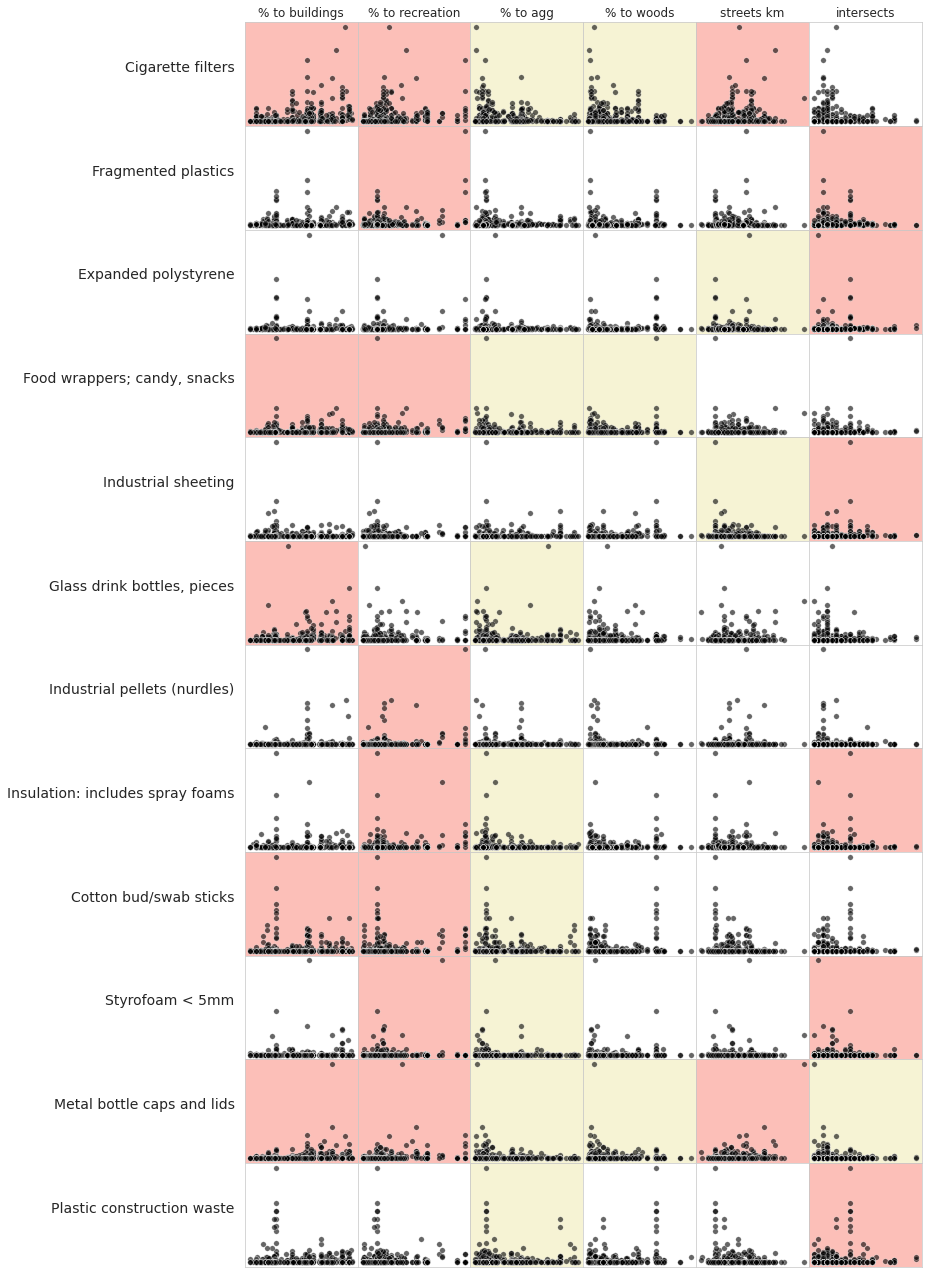

In [8]:

fig, axs = plt.subplots(len(abundant_codes),len(luse_exp), figsize=(len(luse_exp)+7,len(abundant_codes)+6), sharey='row')

for i,code in enumerate(abundant_codes):
    data = new_som_data[new_som_data.code == code]
    for j, n in enumerate(luse_exp):
        ax=axs[i, j]
        ax.grid(False)
        ax.tick_params(axis='both', which='both',bottom=False,top=False,labelbottom=False, labelleft=False, left=False)
       
        if i == 0:
            ax.set_title(F"{n}")
        else:
            pass
        
        if j == 0:
            ax.set_ylabel(F"{code_description_map[code]}", rotation=0, ha='right', **ck.xlab_k14)
            ax.set_xlabel(" ")
        else:
            ax.set_xlabel(" ")
            ax.set_ylabel(" ")
               
        _, corr, a_p = make_plot_with_spearmans(data, ax, n)
        
        if a_p < 0.05:
            if corr > 0:
                ax.patch.set_facecolor('salmon')
                ax.patch.set_alpha(0.5)
            else:
                ax.patch.set_facecolor('palegoldenrod')
                ax.patch.set_alpha(0.5)

plt.tick_params(labelsize=14, which='both', axis='both')
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(F"{project_directory}/test_one.jpg", dpi=300)
plt.show()

#### Correlated values

**Interpreting results** 

The correlation results should allways be considered in conjuction with the number of samples. 

1. A positive correlation means that the land use attribute or feature had increased survey results when compared to other locations. This may be due to a covariance of attributes, either way **a positive correlation is a signal that the survey locations are near a zone of accumulation or a source**. This signal should be assessed along with the other key indicators at the responsible administrative level.

2. A negative correlation means that the land use feature or attribute does not facilitate the accumulation of the object. This result is common for aggricultural areas and woods on the national level. **A negative correlation is a signal that the locations are not a zone of accumulation for the object**.

3. No correlation means that the land use attribute or feature had no accumulating effect on the survey results for that object. The fail rate of the objects with none or few correlations should be consulted, especially when considering the most common objects:

   1. Objects that have few correlations and a high fail rate are ubiquitous
   2. Objects that have few correlations, low fail rate and high pcs/m maybe close to a source


#### Conclusion


Overall, surveys at locations with more buildings and more recreation sites had more trash (all objects considered). However, when the most common objects are considered, only six out of the twelve were found at higher rates in the presence of more buildings or recreational facilities. Of those objects: cigarette ends, candy wrappers, drink bottles and drink lids are likely related to local consumption. Objects associated with food consumption or smoking are found at higher rates in locations that have more space attributed to human interaction as opposed to space devoted to farming or forestry, this has been observed in other studies indifferent of the statistical method<sup>5,6,7,8</sup>. 

There are six objects that fit the third criteria:

1.  objects that have high fail rate and few correlations
    * plastic conststruction waste
    * fragmented plastics
    * industrial sheeting
    * expanded polystyrene
    * glass or ceramic drink bottles


2. few correlations, low fail rate, high pcs/m
   * industrial pellets

The objects in the first group are just as likely to be found indifferent of the location, in general they make up 50% - 60% of the total trash found. Industrial pellets (group 2) are found in only 1/3 surveys, their presence in the most common objects list means they have been found in important quantities at select locations and some of those locations have a relativeley high % of land attributed to recreation.

Each survey area is independent of the other, therfore it is expected that the correlation results will look different for each survey area or lake where this analysis is applied. Along with the key indicators, the variance in the corellation values for different regions is a clear indicator of the unique challenges encountered at different administrative levels.

### How to use this data: locate zones of accumulation in a survey area and identify the relevant land-use features

A correlation table is provided for each survey area with the data summary. The correlation tables should always be considered in conjunction with the median pcs/m and the number of samples that are being used to test the condition. 

In [9]:
author = "roger@hammerdirt.ch"
my_message = "Love what you do. \u2764\ufe0f"
md(F"""### <span style="color:#000099">Have a great day</span>
**This project was made possible by the Swiss federal office for the environment.**<br>

>{my_message}<br>

*{author}* pushed the run button on {today}.<br>
This document originates from https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021 all copyrights apply.<br>
""")

### <span style="color:#000099">Have a great day</span>
**This project was made possible by the Swiss federal office for the environment.**<br>

>Love what you do. ❤️<br>

*roger@hammerdirt.ch* pushed the run button on 2021-07-04.<br>
This document originates from https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021 all copyrights apply.<br>


**Notes**

¹ see the section 'key indicators'<br><br>
² [Statistique suisse de superficie](https://www.bfs.admin.ch/bfs/fr/home/services/geostat/geodonnees-statistique-federale/sol-utilisation-couverture/statistique-suisse-superficie/utilisation-sol.assetdetail.4103545.html)<br><br>
³ [swissTLMRegio](https://www.swisstopo.admin.ch/de/geodata/landscape/tlmregio.html)<br><br>
⁴ [Spearmans ranked correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)<br><br>
⁵ [Implementation of spearmans ranked correlation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html)<br><br>
⁶ C. Aydın et al, The Influence of Land Use on Coastal Litter: An Approach to Identify Abundance and Sources in the Coastal Area of Cilician Basin, Turkey. January 2016, Turkish Journal of Fisheries and Aquatic Sciences 16(1):29-39

Eight land use parameters were estimated:

1. use of beach
2. presence or abscence of food sellers
3. presence of weekend homes
4. straight line distance to nearest river mouth
5. air-line distance to nearest industrial area
6. air-line distance to nearest commercial area
7. agriculture 8km radius
8. population 8km radius

> *Multivariate  Adaptive  Regression  Splines  (MARS) (Friedmann   1991).   MARS   is   an   adaptive   non-parametric   regression   technique   using   piecewise linear  segments  to  describe  non-linear  relationships between a response variable and a set of predictors. In one  of  its  implementations,  MARS  can  be  used  to select  parameters  which  have  a  strong  effect  on  the response  variable.  Accordingly,  in  this  study  MARS is  used  to  identify  a  set  of  environmental  predictors (i.e. origins),  that  is  likely  to  have  strong  functional links with the obtained functiondensities.* 
<br><br>

⁷ Araújo MCB, Silva-Cavalcanti JS and Costa MF, (2018) Anthropogenic Litter on Beaches With Different Levels of Development and Use: A Snapshot of a Coast in Pernambuco (Brazil). Frontiers in marine science. Mar. Sci. 5:233.doi: 10.3389/fmars.2018.00233

Beaches were classified into three groups according to the level of urbanization:

* Low
* Medium
* High

>The beach groups differed from each other with respect to the level of urbanization, use, and environmental conditions. Units of 100×1 of the strandline (maximum level reached by the tide and where anthropogenic litter was deposited) were sampled.
An  analysis  of  variance  (ANOVA)  was  performed  to determine the possible differences in the total number of litter items when compared between beaches in each group. The premises of normality and homoscedasticity were assumed. Where the ANOVA indicated a significant difference, a Tukey test followed by an HSD test was used to determine which beaches and items were significantly different at the 0.05 level of probability.
Although the same types of waste occurred on all beaches, the mean amount varied, especially among groups,and increased according to the level of urbanization when considering the total per group.
<br><br>

⁸ Grelaud, M., Ziveri, P. The generation of marine litter in Mediterranean island beaches as an effect of tourism and its mitigation. Sci Rep 10, 20326 (2020).https://doi.org/10.1038/s41598-020-77225-5

In order to evaluate the seasonal variation of marine litter as an effect of tourism on sandy beaches of Mediterranean islands, 147 surveys were conducted in 2017 during both the low and high touristic season, from February to November. For each of the eight participating islands (Mallorca—Spain, Sicily—Italy, Rab—Croatia, Malta—Malta, Crete, Mykonos and Rhodes—Greece, and Cyprus), three different beaches were selected: a very touristic beach (Tbeach), a beach mainly used by locals (Lbeach) and a remote beach (Rbeach) with limited use by humans. For each beach, a periodic monitoring was performed on the same fixed 100m portion, covering the area going from the water line to the back of the beach. Here, any item found was collected, characterized and properly disposed of. 

> Taken together, the AR of the items from the ST category, the MePs and the MPs show a clear seasonal pattern. This seasonal variation mimics the average number of tourists welcomed in the participating islands for the Tbeach and the Lbeach. During each month of the high season, the items from the ST category represent on average 65.7% ± 2.8% (Tbeach), 39.8% ± 17.9% (Lbeach) and 35.5% ± 28.7% (Rbeach) of the items accumulating on the beaches
<br><br>

⁹ Van Loon, W., Hanke, G., Fleet, D., Werner, S., Barry, J., Strand, J., Eriksson, J., Galgani, F., Gräwe, D., Schulz, M., Vlachogianni, T., Press, M., Blidberg, E. and Walvoort, D., A European threshold value and assessment method for macro litter on coastlines, EUR 30347 EN, Publications Office of the European Union, Luxembourg, 2020, ISBN 978-92-76-21444-1 (online), doi:10.2760/54369 (online), JRC121707.


> Considering uncertainties of data and the resulting confidence intervals, the resulting threshold value can be considered as reached statistically, if the lower 95% confidence limit of the aggregated monitoring values touches the upper 95% confidence limit of the 10th percentile of the baseline data. At this point, the assessment value and threshold value are not significantly differentany more.This  corresponds  to  a median  assessment value  of  approx.  20,  for  a  range  of 40  to 100  assessment surveys. A  similar  statistical  method  is  used in  the  TV  proposalfor  plastics  in  fulmar  stomachs.
<br><br>

<sup>10</sup> Hanke G., Walvoort D., van Loon W., Addamo A.M., Brosich A., del Mar Chaves Montero M., Molina Jack M.E., Vinci M., Giorgetti A., EU Marine Beach Litter Baselines, EUR 30022 EN, Publications Office of the European Union, Luxemburg, 2019, ISBN 978-92-76-14243-0, doi:10.2760/16903, JRC114129.

> After consideration of advantages and disadvantages of the different methods, calculations have been made by using mean, median and trimean in order to compare results from these different calculation scenarios. Considering the implications of various factors, such as the robustness of the method against extreme values but also the transparency of the calculation method, the TGMLagreed to use the median as the calculation method to average beach litter data across surveys.
<br><br>

<sup>11</sup> Hanke, G. et al. Guidance on Monitoring of Marine Litter in European Seas. Publications Office of the European Union. JRC83985. (2013). https://doi.org/10.2788/99475.
<br><br>
<sup>12</sup> Ryan, P. G. A brief history of marine litter research. In Marine Anthropogenic Litter 1–25 (Springer International Publishing, New York, 2015). https://doi.org/10.1007/978-3-319-16510-3_1.
<br><br>
<sup>13</sup> Veiga, J.M., Fleet, D., Kinsey, S., Nilsson, P., Vlachogianni, T., Werner, S., Galgani, F., Thompson, R.C., Dagevos, J., Gago, J., Sobral, P. and Cronin, R.;2016;Identifying Sources of Marine Litter. MSFD GES TG Marine Litter Thematic Report;JRC Technical Report;EUR28309; doi:10.2788/018068
<br><br>

<sup>14</sup> van Emmerik, T.H.M. and Vriend, P., 2021. Roadmap Litter Monitoring in Dutch Rivers. Wageningen, Wageningen University, Report. 44 pp., https:// doi.org/10.18174/537439/van Emmerik, T.H.M. and Vriend, P., 2021. Roadmap Litter Monitoring in Dutch Rivers.